In [2]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
# This line is only needed if you have a HiDPI display
%config InlineBackend.figure_format = 'retina'

from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.preprocessing import StandardScaler

## Define a class to hold the information describing our model for convenient access.

In [1]:
class SMOModel:
    """Container object for the model used for sequential minimal optimization."""

    def __init__(self, X, y, C, kernel, alphas, b, errors):
        self.X = X          # training data vector
        self.y = y          # class label vector
        self.C = C          # regularization parameter
        self.kernel = kernel     # kernel function
        self.alphas = alphas     # lagrange multiplier vector
        self.b = b          # scalar bias term
        self.errors = errors     # error cache
        self._obj = []        # record of objective function value
        self.m = len(self.X)     # store size of training set

## Now we define different kernel functions

In [3]:
def linear_kernel(x, y, b=1):
    """Returns the linear combination of arrays `x` and `y` with
    the optional bias term `b` (set to 1 by default)."""

    return x @ y.T + b # Note the @ operator for matrix multiplication


def gaussian_kernel(x, y, sigma=1):
    """Returns the gaussian similarity of arrays `x` and `y` with
    kernel width parameter `sigma` (set to 1 by default)."""

    if np.ndim(x) == 1 and np.ndim(y) == 1:
        result = np.exp(- (np.linalg.norm(x - y, 2)) ** 2 / (2 * sigma ** 2))
    elif (np.ndim(x) > 1 and np.ndim(y) == 1) or (np.ndim(x) == 1 and np.ndim(y) > 1):
        result = np.exp(- (np.linalg.norm(x - y, 2, axis=1) ** 2) / (2 * sigma ** 2))
    elif np.ndim(x) > 1 and np.ndim(y) > 1:
        result = np.exp(- (np.linalg.norm(x[:, np.newaxis] - y[np.newaxis, :], 2, axis=2) ** 2) / (2 * sigma ** 2))
    return result

def polynomial_kernel(x, y, poly_constant=1, poly_power=4):

    projection = x @ y.T
    result = (projection + poly_constant) ** poly_power

    return result

Let's test the kernel function

In [ ]:
x_len, y_len = 5, 10

In [ ]:
linear_kernel(np.random.rand(x_len, 1), np.random.rand(y_len, 1)).shape == (x_len,y_len)

True

In [ ]:
gaussian_kernel(np.random.rand(x_len, 1), np.random.rand(y_len, 1)).shape == (x_len,y_len)

True

In [ ]:
polynomial_kernel(np.random.rand(x_len, 1), np.random.rand(y_len, 1)).shape == (x_len,y_len)

True

## Optimal Objective and decision functions

In [4]:
# Objective function to optimize

def objective_function(alphas, target, kernel, X_train):
    """Returns the SVM objective function based in the input model defined by:
    `alphas`: vector of Lagrange multipliers
    `target`: vector of class labels (-1 or 1) for training data
    `kernel`: kernel function
    `X_train`: training data for model."""

    return np.sum(alphas) - 0.5 * np.sum((target[:, None] * target[None, :]) * kernel(X_train, X_train) * (alphas[:, None] * alphas[None, :]))


# Decision function

def decision_function(alphas, target, kernel, X_train, x_test, b):
    """Applies the SVM decision function to the input feature vectors in `x_test`."""

    result = (alphas * target) @ kernel(X_train, x_test) - b
    return result

Draw decision boundary

In [6]:
def plot_decision_boundary(model, ax, resolution=100, colors=('b', 'k', 'y'), levels=(-1, 0, 1)):
        """Plots the model's decision boundary on the input axes object.
        Range of decision boundary grid is determined by the training data.
        Returns decision boundary grid and axes object (`grid`, `ax`)."""

        # Generate coordinate grid of shape [resolution x resolution]
        # and evaluate the model over the entire space
        xrange = np.linspace(model.X[:,0].min(), model.X[:,0].max(), resolution)
        yrange = np.linspace(model.X[:,1].min(), model.X[:,1].max(), resolution)
        grid = [[decision_function(model.alphas, model.y,
                                   model.kernel, model.X,
                                   np.array([xr, yr]), model.b) for xr in xrange] for yr in yrange]
        grid = np.array(grid).reshape(len(xrange), len(yrange))

        # Plot decision contours using grid and
        # make a scatter plot of training data
        ax.contour(xrange, yrange, grid, levels=levels, linewidths=(1, 1, 1),
                   linestyles=('--', '-', '--'), colors=colors)
        ax.scatter(model.X[:,0], model.X[:,1],
                   c=model.y, cmap=plt.cm.viridis, lw=0, alpha=0.25)

        # Plot support vectors (non-zero alphas)
        # as circled points (linewidth > 0)
        mask = np.round(model.alphas, decimals=2) != 0.0
        ax.scatter(model.X[mask,0], model.X[mask,1],
                   c=model.y[mask], cmap=plt.cm.viridis, lw=1, edgecolors='k')

        return grid, ax

## Sequential minimal optimization

This code is written based on the pseudocode provided in Platt's paper(https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf).

The whole process of this algorithm is comprise of the following three parts:
1. take_step()
2. examine_example()
3. train()

The order of these functions run is **train() choose the first alpha** and pass it to examine_example(), the **examine_example() choose the second alpha** and **pass both two alpha choosed to take_step()**.

### take_step()

This function computes the **two new alpha** values, a **new threshold b**, and updates the **error cache**.

In [5]:
def take_step(i1, i2, model):

    # Skip if chosen alphas are the same
    if i1 == i2:
        return 0, model

    alph1 = model.alphas[i1]
    alph2 = model.alphas[i2]
    y1 = model.y[i1]
    y2 = model.y[i2]
    E1 = model.errors[i1]
    E2 = model.errors[i2]
    s = y1 * y2

    # Compute L & H, the bounds on new possible alpha values
    if (y1 != y2):
        L = max(0, alph2 - alph1)
        H = min(model.C, model.C + alph2 - alph1)
    elif (y1 == y2):
        L = max(0, alph1 + alph2 - model.C)
        H = min(model.C, alph1 + alph2)
    if (L == H):
        return 0, model

    # Compute kernel & 2nd derivative eta
    k11 = model.kernel(model.X[i1], model.X[i1])
    k12 = model.kernel(model.X[i1], model.X[i2])
    k22 = model.kernel(model.X[i2], model.X[i2])
    eta = 2 * k12 - k11 - k22

    # Compute new alpha 2 (a2) if eta is negative
    if (eta < 0):
        a2 = alph2 - y2 * (E1 - E2) / eta
        # Clip a2 based on bounds L & H
        if L < a2 < H:
            a2 = a2
        elif (a2 <= L):
            a2 = L
        elif (a2 >= H):
            a2 = H

    # If eta is non-negative, move new a2 to bound with greater objective function value
    else:
        alphas_adj = model.alphas.copy()
        alphas_adj[i2] = L
        # objective function output with a2 = L
        Lobj = objective_function(alphas_adj, model.y, model.kernel, model.X)
        alphas_adj[i2] = H
        # objective function output with a2 = H
        Hobj = objective_function(alphas_adj, model.y, model.kernel, model.X)
        if Lobj > (Hobj + eps):
            a2 = L
        elif Lobj < (Hobj - eps):
            a2 = H
        else:
            a2 = alph2

    # Push a2 to 0 or C if very close
    if a2 < 1e-8:
        a2 = 0.0
    elif a2 > (model.C - 1e-8):
        a2 = model.C

    # If examples can't be optimized within epsilon (eps), skip this pair
    if (np.abs(a2 - alph2) < eps * (a2 + alph2 + eps)):
        return 0, model

    # Calculate new alpha 1 (a1)
    a1 = alph1 + s * (alph2 - a2)

    # Update threshold b to reflect newly calculated alphas
    # Calculate both possible thresholds
    b1 = E1 + y1 * (a1 - alph1) * k11 + y2 * (a2 - alph2) * k12 + model.b
    b2 = E2 + y1 * (a1 - alph1) * k12 + y2 * (a2 - alph2) * k22 + model.b

    # Set new threshold based on if a1 or a2 is bound by L and/or H
    if 0 < a1 and a1 < C:
        b_new = b1
    elif 0 < a2 and a2 < C:
        b_new = b2
    # Average thresholds if both are bound
    else:
        b_new = (b1 + b2) * 0.5

    # Update model object with new alphas & threshold
    model.alphas[i1] = a1
    model.alphas[i2] = a2

    # Update error cache
    # Error cache for optimized alphas is set to 0 if they're unbound
    for index, alph in zip([i1, i2], [a1, a2]):
        if 0.0 < alph < model.C:
            model.errors[index] = 0.0

    # Set non-optimized errors based on equation 12.11 in Platt's book
    non_opt = [n for n in range(model.m) if (n != i1 and n != i2)]
    model.errors[non_opt] = model.errors[non_opt] + \
                            y1*(a1 - alph1)*model.kernel(model.X[i1], model.X[non_opt]) + \
                            y2*(a2 - alph2)*model.kernel(model.X[i2], model.X[non_opt]) + model.b - b_new

    # Update model threshold
    model.b = b_new

    return 1, model

### examine_example()

This function implements **the second choice heuristic** to choose **the second alpha to optimize**, and **passes the index of both alpha** values to take_step().

In [6]:
def examine_example(i2, model):

    y2 = model.y[i2]
    alph2 = model.alphas[i2]
    E2 = model.errors[i2]
    r2 = E2 * y2

    # Proceed if error is within specified tolerance (tol)
    if ((r2 < -tol and alph2 < model.C) or (r2 > tol and alph2 > 0)):

        if len(model.alphas[(model.alphas != 0) & (model.alphas != model.C)]) > 1:
            # Use 2nd choice heuristic is choose max difference in error
            if model.errors[i2] > 0:
                i1 = np.argmin(model.errors)
            elif model.errors[i2] <= 0:
                i1 = np.argmax(model.errors)
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model

        # Loop through non-zero and non-C alphas, starting at a random point
        for i1 in np.roll(np.where((model.alphas != 0) & (model.alphas != model.C))[0],
                          np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model

        # loop through all alphas, starting at a random point
        for i1 in np.roll(np.arange(model.m), np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model

    return 0, model

### train()

This function implements **selection of the first alpha** to optimize via **the first choice heuristic** and passes this value to examine_example().

In [7]:
def train(model):

    numChanged = 0
    examineAll = 1

    while(numChanged > 0) or (examineAll):
        numChanged = 0
        if examineAll:
            # loop over all training examples
            for i in range(model.alphas.shape[0]):
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(model.alphas, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        else:
            # loop over examples where alphas are not already at their limits
            for i in np.where((model.alphas != 0) & (model.alphas != model.C))[0]:
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(model.alphas, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        if examineAll == 1:
            examineAll = 0
        elif numChanged == 0:
            examineAll = 1

    return model

## Prediction function to evaluate the accuracy

In [8]:
def predict(model, X):
    """Make predictions with a trained SMOModel."""
    # Compute the decision function based on the support vectors
    # For a linear kernel, this is just the dot product plus the bias term
    # For non-linear kernels, you would need to apply the kernel function between X and the support vectors
    n_samples, _ = X.shape
    predictions = np.zeros(n_samples)
    for i in range(n_samples):
        prediction = 0
        for alpha, support_vector_y, support_vector in zip(model.alphas, model.y, model.X):
            prediction += alpha * support_vector_y * model.kernel(support_vector, X[i])
        prediction += model.b
        predictions[i] = np.sign(prediction)
    return predictions

## Test the model on dataset in Artifcial domains using different kernels

### k Gaussian sources

In [11]:
centers_close = np.array([[0, 0], [2, 2]])
centers_far = np.array([[0, 0], [5, 5]])

X_train, y = make_blobs(n_samples=1000, centers=2, n_features=2, random_state=1)
#X_train, y = make_blobs(n_samples=1000, centers=10, n_features=2, random_state=1)
# change centers to vary the number of sources
# change n_features to vary the number of dimensions

In [49]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y)
# Scale the data to be centered at the origin with a unit standard deviation

In [50]:
y[y == 0] = -1

# Change the class labels to be +1 and -1 instead of 0 and 1.

In [51]:
X_train_scaled, X_test, y, y_test = train_test_split(X_train_scaled, y, test_size=0.3, random_state=42)

In [52]:
# Set model parameters and initial values
C = 100.0
m = len(X_train_scaled)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Set tolerances
tol = 0.01 # error tolerance
eps = 0.01 # alpha tolerance

# Instantiate model
model = SMOModel(X_train_scaled, y, C, linear_kernel, initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel, model.X, model.X, model.b) - model.y
model.errors = initial_error

In [53]:
np.random.seed(0)
output = train(model)
%timeit train(model)
# Train the model on blobs

717 µs ± 174 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [55]:
# Assuming X_test and y_test are your test features and labels
y_pred = predict(model, X_test)

# Evaluate the model
accuracy = np.mean(y_pred == y_test)
print(f"Model accuracy: {accuracy:.4f}")

Model accuracy: 1.0000


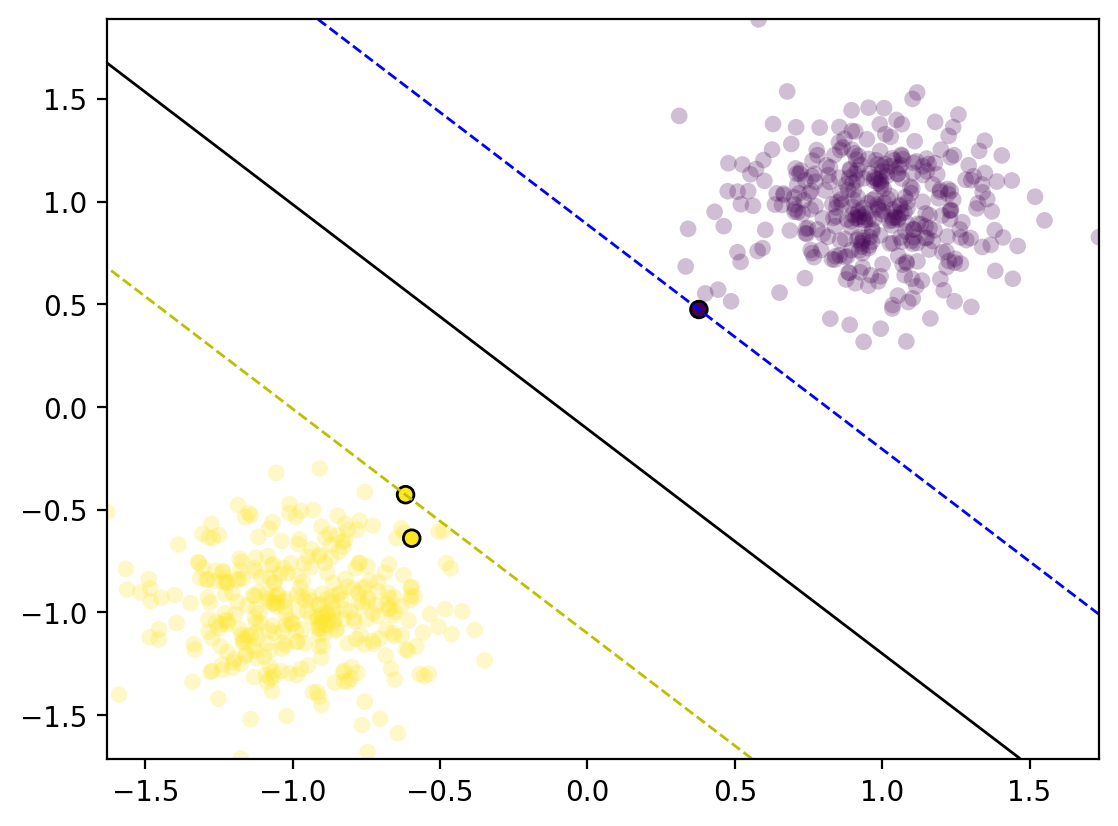

In [54]:
fig, ax = plt.subplots()

grid, ax = plot_decision_boundary(output, ax)

#  Draw the decision boundary

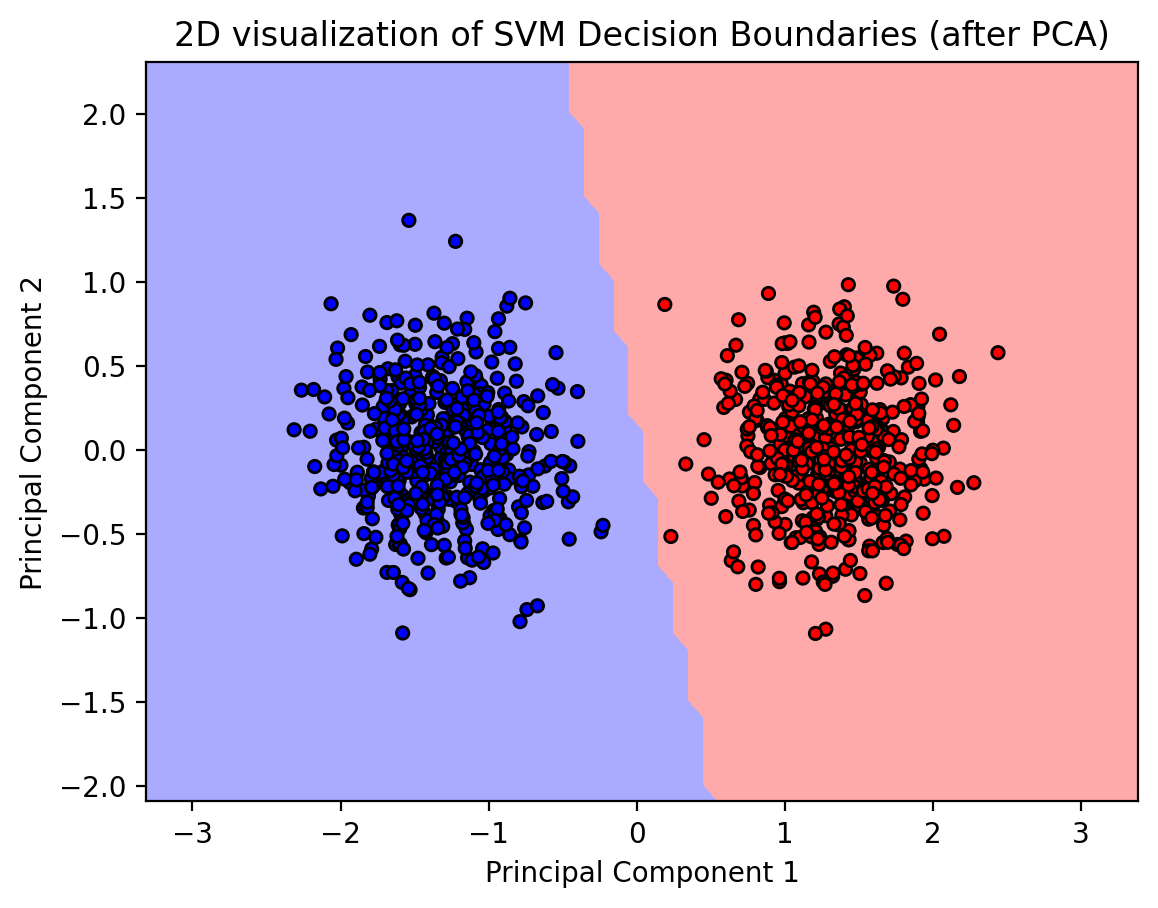

In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap

centers_close = np.array([[0, 0], [2, 2]])
centers_far = np.array([[0, 0], [5, 5]])

# Generate synthetic data
X, y = make_blobs(n_samples=1000, n_features=300, centers=centers_far, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X, y)

# Fit SVM classifier
clf = SVC(kernel='linear', C=100)
clf.fit(X, y)

# Reduce data to two principal components for visualization
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_train_scaled)

# Fit SVM to reduced data for visualization purposes
clf_reduced = SVC(kernel='linear')
clf_reduced.fit(X_reduced, y)

# Create grid to evaluate model
x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Plot decision boundary
Z = clf_reduced.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Set color for plots
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

plt.contourf(xx, yy, Z, cmap=cmap_light)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
plt.title('2D visualization of SVM Decision Boundaries (after PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

The circled points are our support vectors. They should be the only points with non-zero alpha values.

In [ ]:
output.alphas.sum()

2.0317808748035873

In [ ]:
# Test the model performance with an outlier
# Add an outlier
X_outlier = np.append(X_train_scaled, [0.1, 0.1])
X_outlier = X_outlier.reshape(X_train.shape[0]+1, X_train.shape[1])
y_outlier = np.append(y, 1)

In [ ]:
# Set model parameters and initial values
C = 100.0
m = len(X_outlier)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Instantiate model
model = SMOModel(X_outlier, y_outlier, C, linear_kernel, initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel, model.X, model.X, model.b) - model.y
model.errors = initial_error

1.05 ms ± 289 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


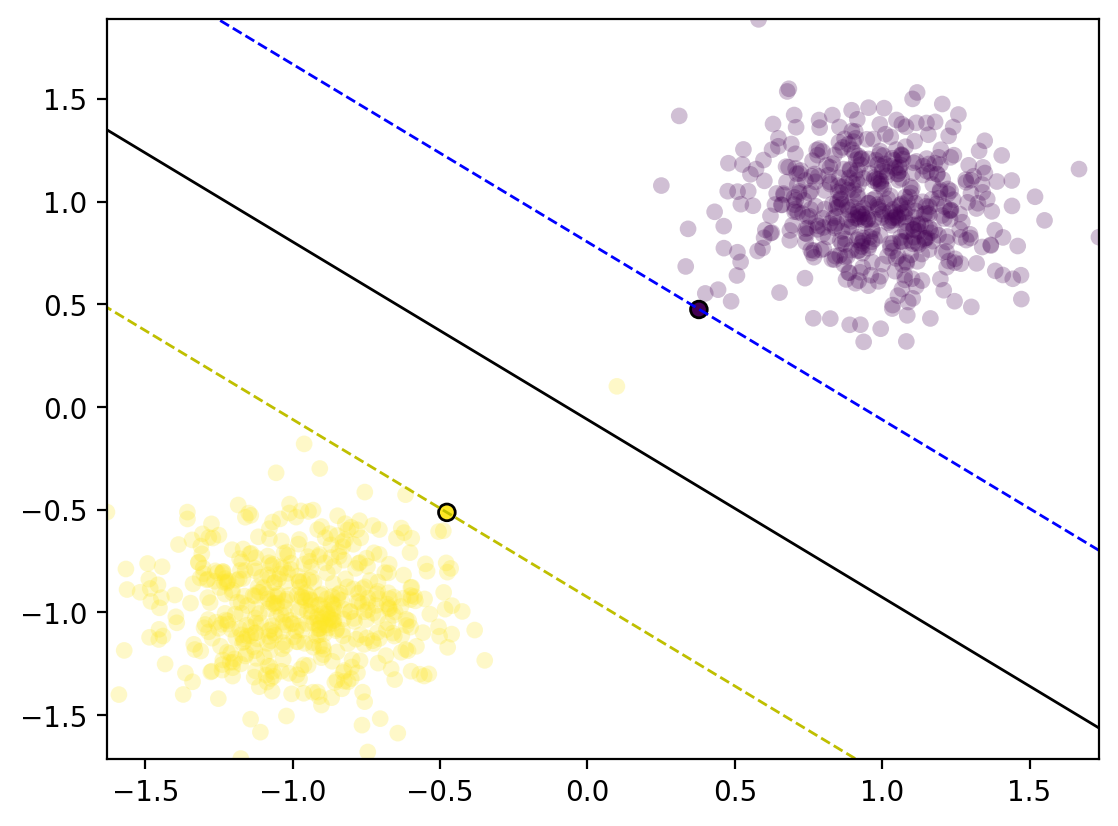

In [ ]:
output = train(model)
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)
%timeit train(model)

What about regularization?

We can see above that a single outlier pushes the decision boundary much farther away from the rest of the population. We can eliminate this effect if we use a softer margin (a **lower value for C**).

In [ ]:
# Set model parameters and initial values
C = 1.0

initial_alphas = np.zeros(m)
initial_b = 0.0

# Instantiate model
model = SMOModel(X_outlier, y_outlier, C, linear_kernel, initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel, model.X, model.X, model.b) - model.y
model.errors = initial_error

The outlier won't influence our decision boundary as much

942 µs ± 97.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


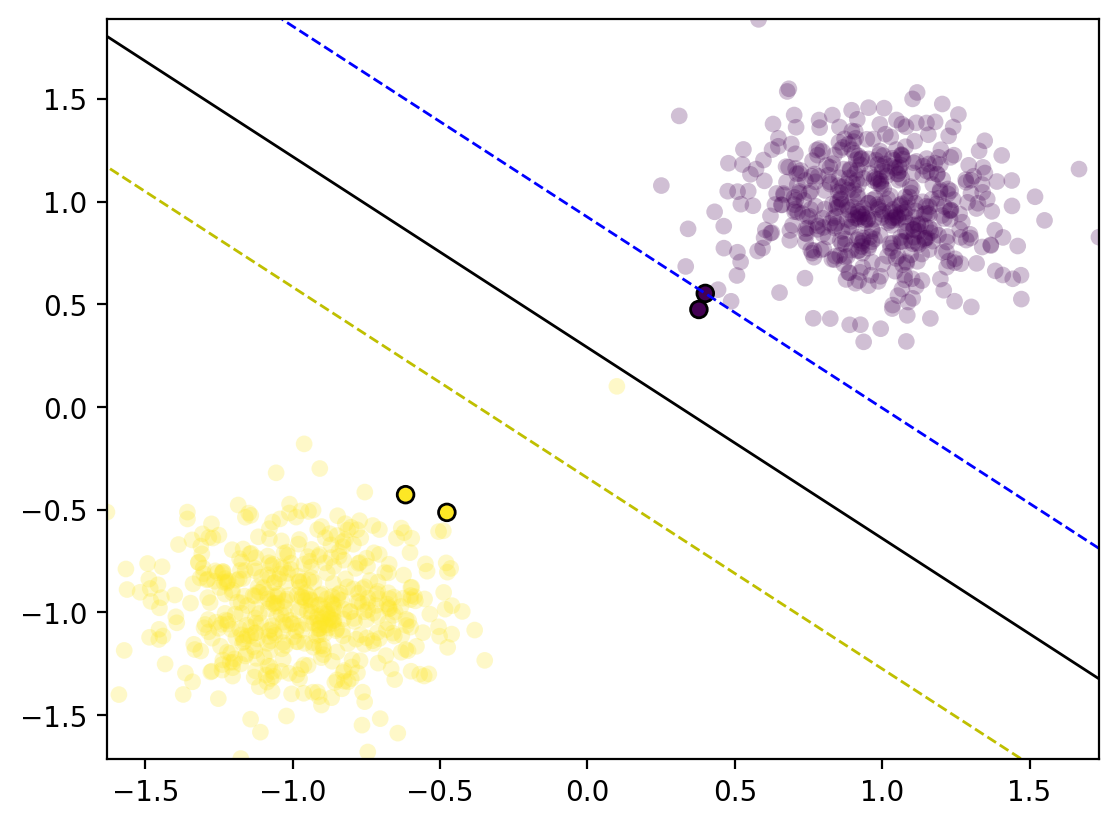

In [ ]:
output = train(model)
%timeit train(model)
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)

In [ ]:
n_samples = 1000
n_features = 2
std_dev = 0.5  # Standard deviation of clusters

# Centers close together
centers_close = np.array([[0, 0], [2, 2]])  # Define centers close to each other

# Generate dataset with centers close together
X_close, y_close = make_blobs(n_samples=n_samples, centers=centers_close, n_features=n_features, cluster_std=std_dev, random_state=42)

# Centers further apart
centers_far = np.array([[0, 0], [5, 5]])  # Define centers far from each other

# Generate dataset with centers further apart
X_far, y_far = make_blobs(n_samples=n_samples, centers=centers_far, n_features=n_features, cluster_std=std_dev, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_close, y)
#X_train_scaled = scaler.fit_transform(X_far, y)

In [ ]:
y_close[y_close == 0] = -1
#y_far[y_far == 0] = -1

In [ ]:
# Set model parameters and initial values
C = 100.0
m = len(X_train_scaled)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Set tolerances
tol = 0.01 # error tolerance
eps = 0.01 # alpha tolerance

# Instantiate model
model = SMOModel(X_train_scaled, y_close, C, linear_kernel, initial_alphas, initial_b, np.zeros(m))
# model = SMOModel(X_train_scaled, y_far, C, linear_kernel, initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel, model.X, model.X, model.b) - model.y
model.errors = initial_error

In [ ]:
np.random.seed(0)
output = train(model)
%timeit train(model)
# Train the model on blobs

41.5 ms ± 11.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


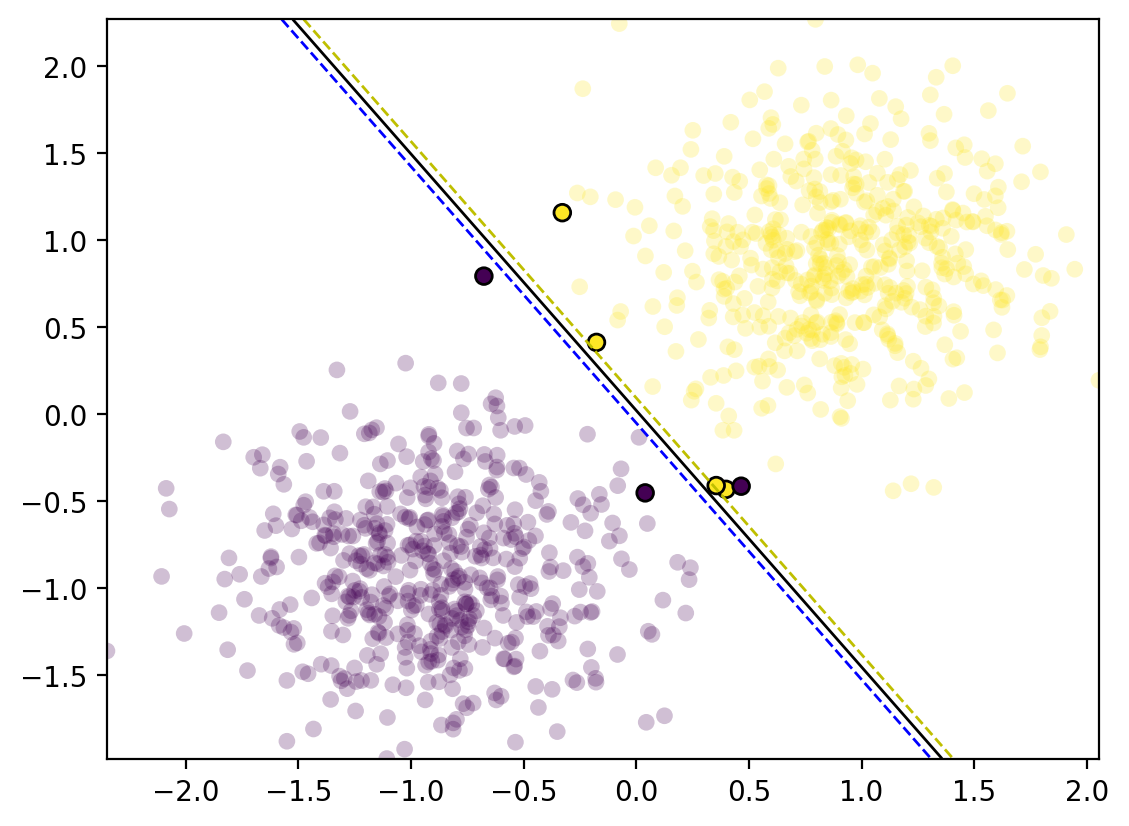

In [ ]:
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)

In [ ]:
X_train, y = make_blobs(n_samples=1000, centers=10, n_features=2, random_state=1)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y)

In [ ]:
n_classes = len(np.unique(y))
print(n_classes)

10


In [ ]:
# Create a list to hold binary classifiers
classifiers = []

In [ ]:
# Convert multi-class labels to binary for One-vs-Rest strategy
for i in range(n_classes):
    # Create binary labels for the current class vs. all other classes
    y_binary = np.where(y == i, 1, -1)

    # Instantiate the binary SVM model for the current class
    model = SMOModel(X_train_scaled, y_binary, C, linear_kernel, initial_alphas, initial_b, np.zeros(m))

    # Initialize error cache for the current model
    initial_error = decision_function(model.alphas, model.y, model.kernel, model.X, model.X, model.b) - model.y
    model.errors = initial_error

    # You would add here the training process for your model, e.g.:
    np.random.seed(0)
    output = train(model)
    %timeit train(model)

    # Store the trained model
    classifiers.append(model)

IndexError: index 10 is out of bounds for axis 0 with size 10

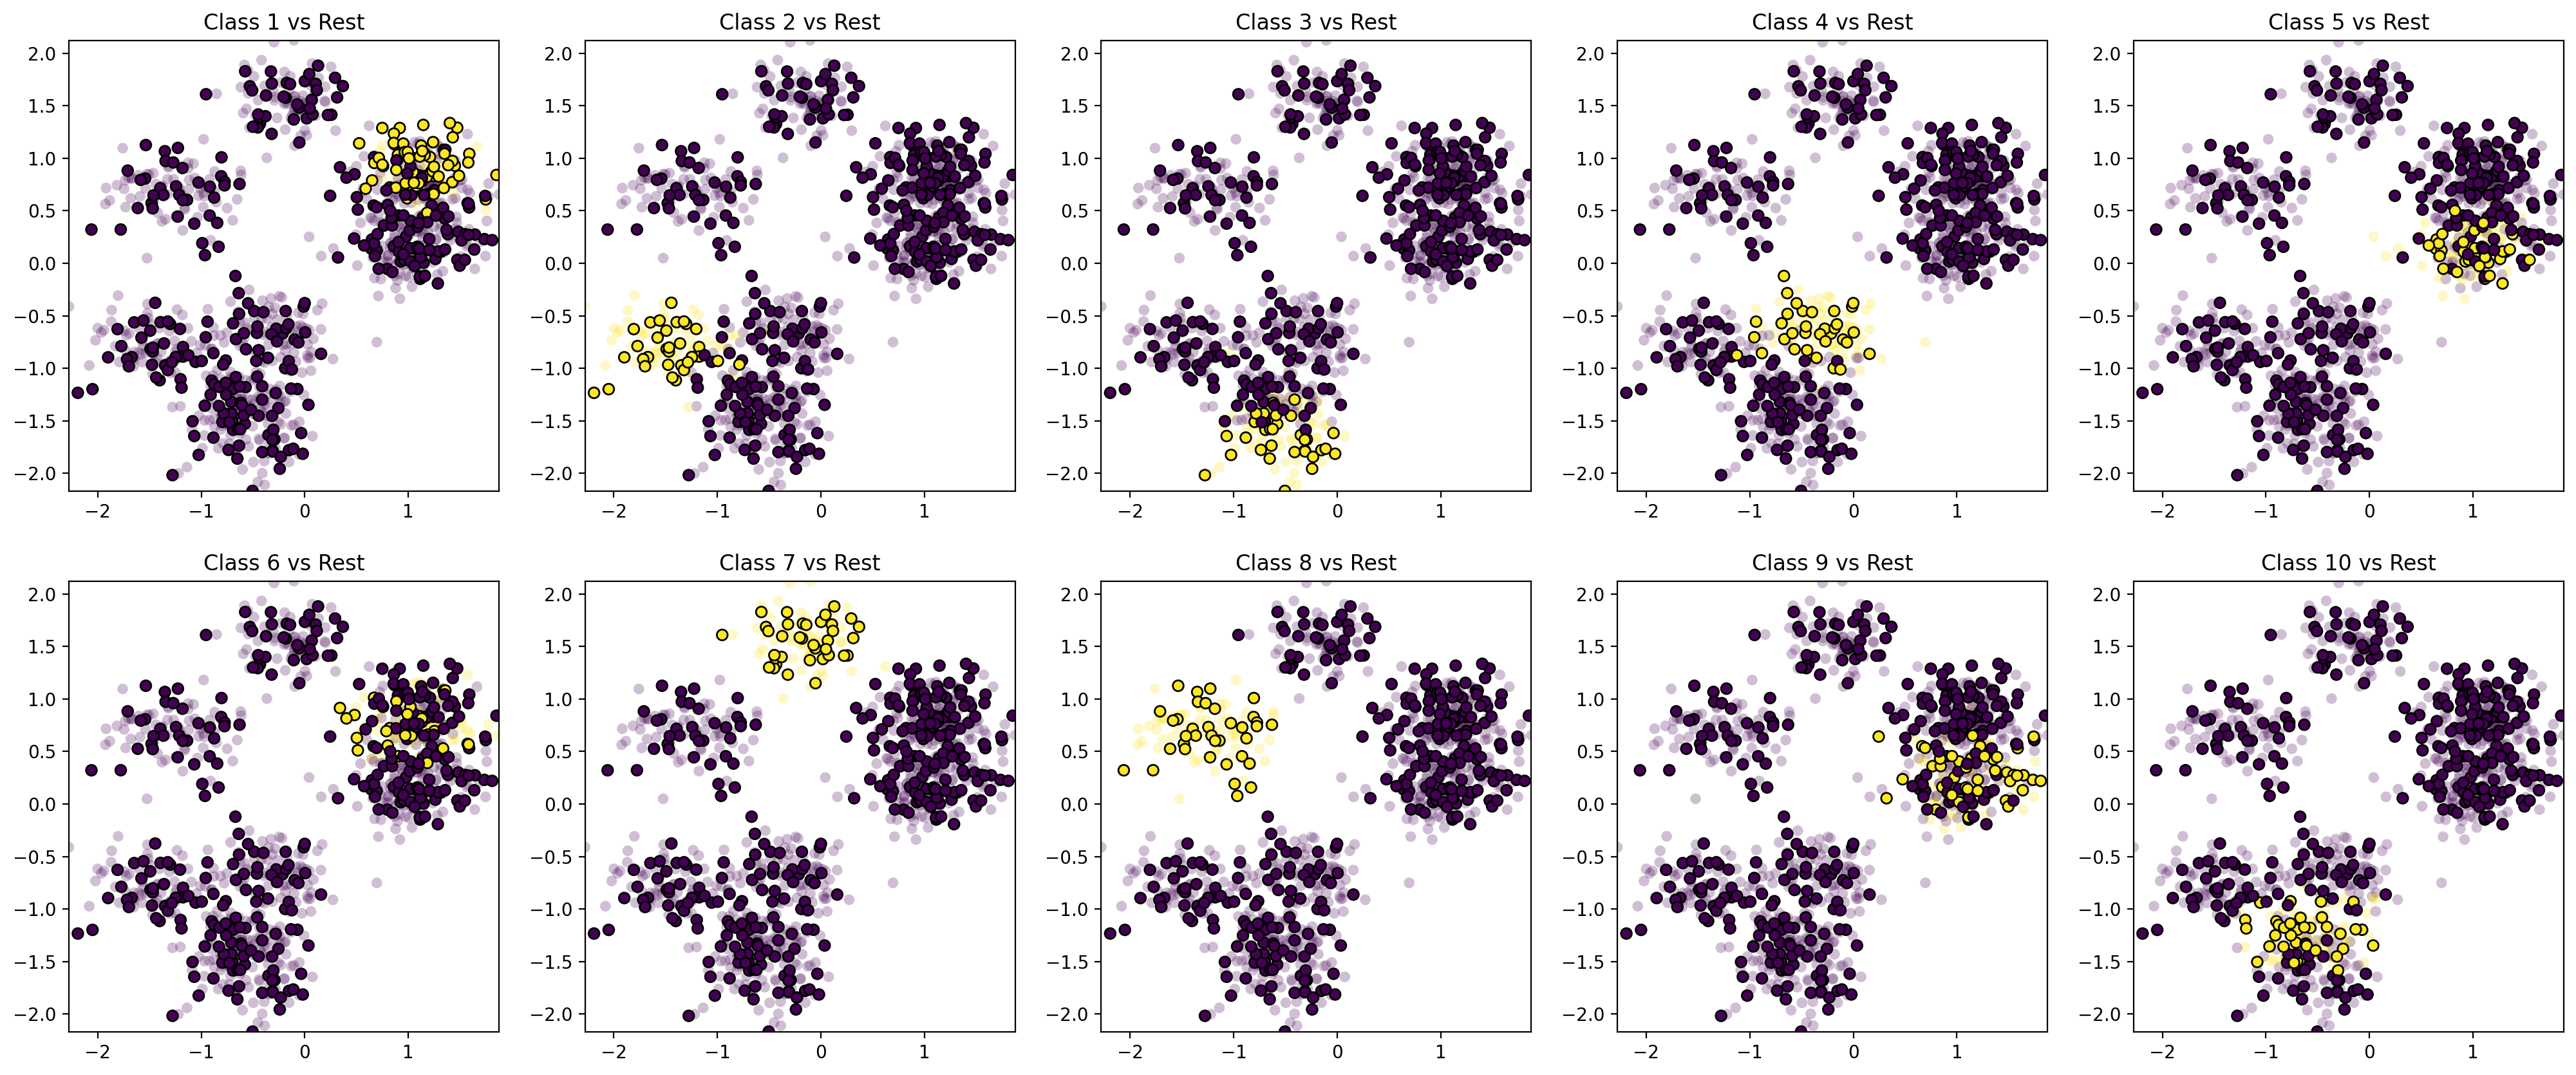

In [ ]:
# Prepare your subplot environment
fig, axs = plt.subplots(2, 5, figsize=(25, 10))  # Adjust for 10 subplots (2 rows, 5 columns)

# Flatten the axs array for easier indexing
axs = axs.flatten()

# Plotting decision boundaries for each model
for i, model in enumerate(classifiers):
    # Assuming your models list is in the correct order for the classes
    # Adjust 'resolution', 'colors', and 'levels' as needed
    plot_decision_boundary(model, axs[i], resolution=100, colors=('b', 'k', 'r'), levels=(-1, 0, 1))
    axs[i].set_title(f'Class {i+1} vs Rest')

# Display the plot
plt.tight_layout()
plt.show()

### Intertwined spiral

In [70]:
import pandas as pd

file_path = '/content/spirals_500.csv'

# Load the CSV file
data = pd.read_csv(file_path)

# Extract the second and third columns as input features
# Assuming columns are indexed from 0, so second column is index 1 and third is index 2
X = data.iloc[:, [1, 2]].values  # Convert to NumPy array

# Extract the fourth column as labels
# Fourth column is index 3
y = data.iloc[:, 3].values  # Convert to NumPy array

In [71]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [68]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X, y)
y[y == 0] = -1

In [69]:
X_train_scaled, X_test, y, y_test = train_test_split(X_train_scaled, y, test_size=0.3, random_state=42)

In [70]:
# Set model parameters and initial values
C = 1000.0
m = len(X_train_scaled)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Set tolerances
tol = 0.01 # error tolerance
eps = 0.01 # alpha tolerance

# Instantiate model
model = SMOModel(X_train_scaled, y, C, lambda x, y: gaussian_kernel(x, y, sigma=1), initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel, model.X, model.X, model.b) - model.y
model.errors = initial_error

892 ms ± 173 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


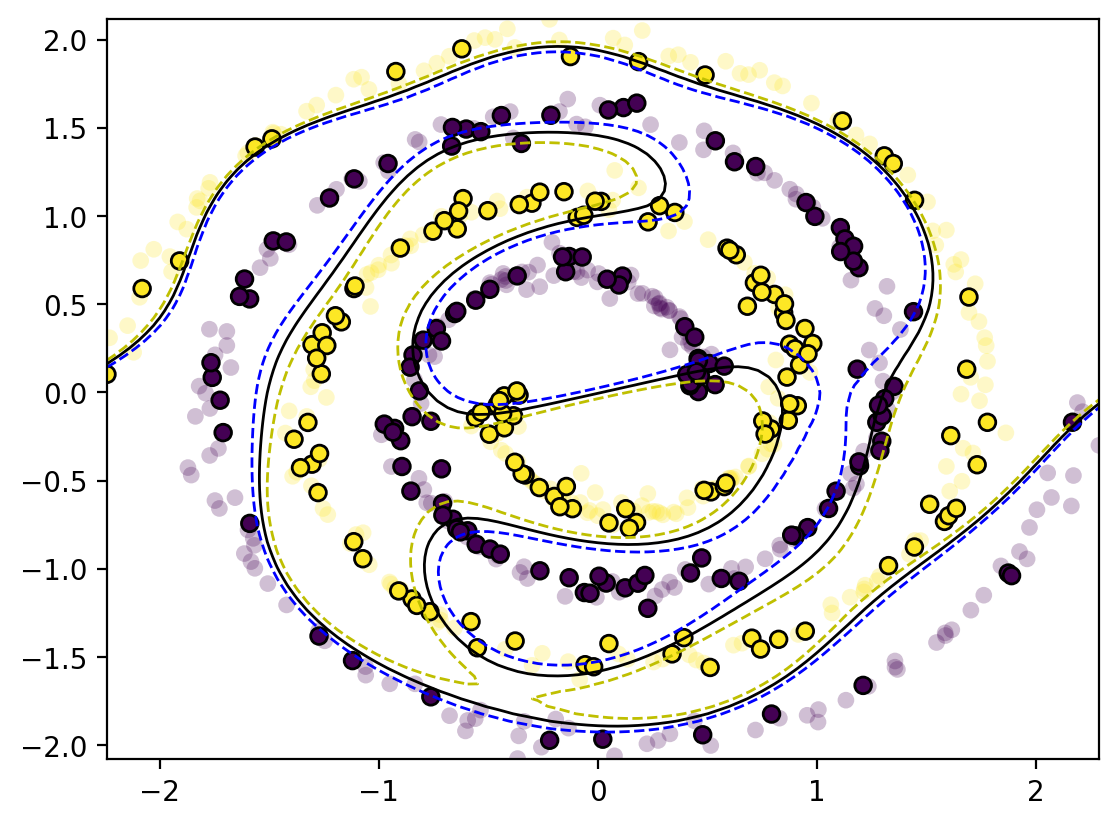

In [71]:
output = train(model)
%timeit train(model)
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)

In [72]:
# Assuming X_test and y_test are your test features and labels
y_pred = predict(model, X_test)

# Evaluate the model
accuracy = np.mean(y_pred == y_test)
print(f"Model accuracy: {accuracy:.4f}")

Model accuracy: 0.5367


110 ms ± 41.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.9983


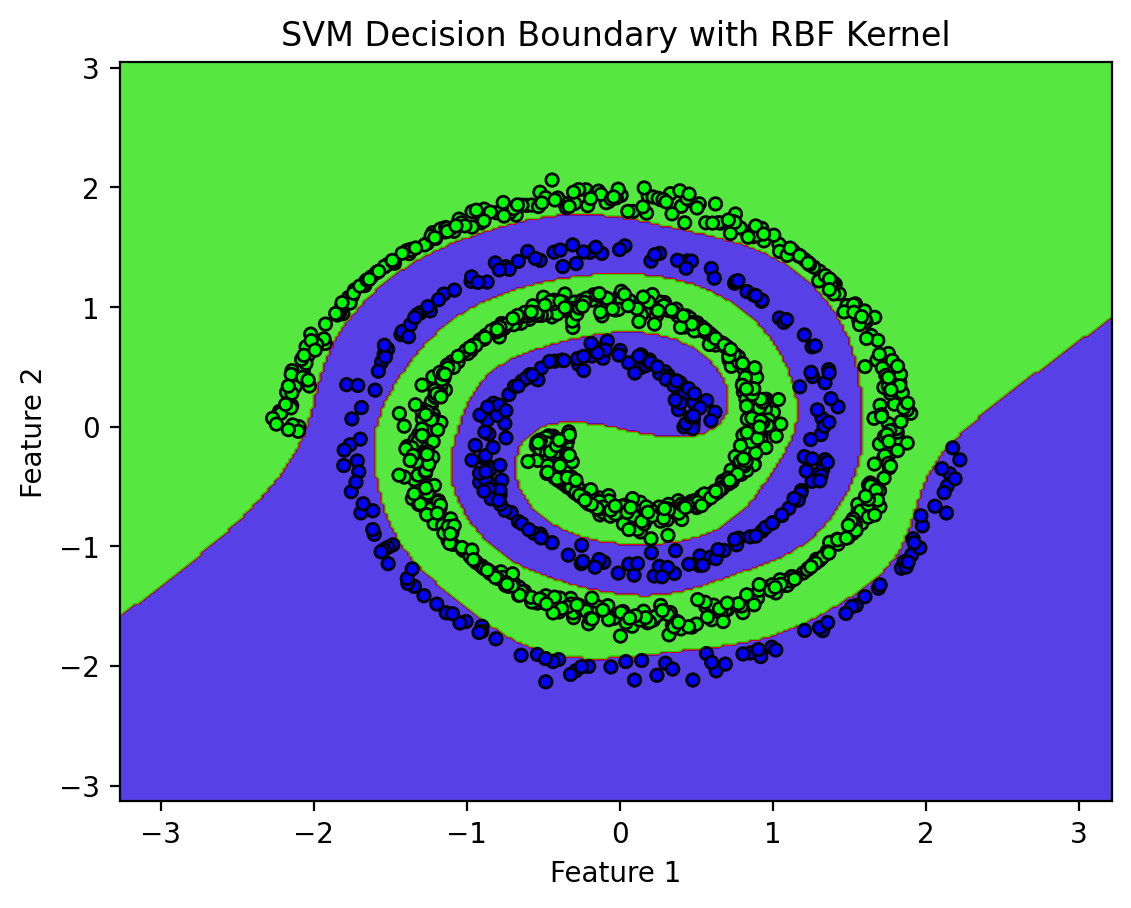

In [29]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Assuming X and y are your data and labels

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the SVM model
model = SVC(C=1000,kernel='rbf',gamma=1)  # Use RBF kernel; you can change kernel and parameters as needed

# Train the SVM model on the training data
model.fit(X_train_scaled, y_train)
%timeit model.fit(X_train_scaled, y_train)

# Predict the labels of the test set
y_pred = model.predict(X_test_scaled)

# Compute the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


# Visualize the decision boundary
# Create a mesh to plot in
x_min, x_max = X_train_scaled[:, 0].min() - 1, X_train_scaled[:, 0].max() + 1
y_min, y_max = X_train_scaled[:, 1].min() - 1, X_train_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Plot decision boundary and margins
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.brg)
plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, s=20, edgecolors='k', cmap=plt.cm.brg)
plt.title('SVM Decision Boundary with RBF Kernel')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

### Adult dataset

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]
adult = pd.read_csv(url, names=column_names)

In [10]:
adult.income.value_counts(normalize=True)

 <=50K    0.75919
 >50K     0.24081
Name: income, dtype: float64

In [11]:
adult.shape # same as Platt's paper

(32561, 15)

In [12]:
# Drop rows with missing values
adult = adult.dropna()
len(adult)

32561

In [13]:
# Convert categorical variables to numerical using LabelEncoder
label_encoders = {}
for column in adult.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    adult[column] = label_encoders[column].fit_transform(adult[column])

# Separate features and target variable
X = adult.drop("income", axis=1).values
y = adult["income"].values

In [14]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [15]:
scaler = StandardScaler()
X = scaler.fit_transform(X, y)
y[y == 0] = -1

In [16]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.951, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.931, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.931, random_state=42)

In [17]:
len(X_train), len(y_train)

(1595, 1595)

In [18]:
# Set model parameters and initial values
C = 1
m = len(X_train)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Set tolerances
tol = 0.01 # error tolerance
eps = 0.01 # alpha tolerance

# Instantiate model
model = SMOModel(X_train, y_train, C, lambda x, y: gaussian_kernel(x, y, sigma=10), initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel, model.X, model.X, model.b) - model.y
model.errors = initial_error

In [19]:
np.random.seed(0)
output = train(model)
%timeit train(model)

2.34 s ± 244 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
# Assuming X_test and y_test are your test features and labels
y_pred = predict(model, X_test)

# Evaluate the model
accuracy = np.mean(y_pred == y_test)
print(f"Model accuracy: {accuracy:.4f}")

Model accuracy: 0.7734
